In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV,RidgeCV,Lasso,Ridge
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
# Data Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# Model Evaluation
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# Model Selection
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.model_selection import train_test_split

# Predicting Medical Insurance Cost

### Content
- age
- bmi
- children
- smoker (yes/no)
- region
- charges (target)



In [ ]:
import warnings
def warn(*args,**kwargs):
  pass
warnings.warn = warn

### Importing Dataset

In [ ]:
### CODE HERE ###
# insert url to csv file uploaded to google drive
# example
# url = 'https://drive.google.com/file/d/1E0j6IpOxQksihlgJ8RXwKuBKscaCMDQ2/view?usp=sharing'
url='https://drive.google.com/file/d/1kaZFoxm0ZmkE_KJnHu0QacXnvsC_aTkD/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()
data = df.copy()

## Dataset Visualization

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
stats_df = df.describe()
stats_df.rename({'50%': 'median'}, inplace=True)
stats_df

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
median,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### If we look at the mean and median we can notice that
- age, bmi and children almost normally distributed.
- charges skewed right.

#### There is no negative value

In [ ]:
# check duplicated values
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [ ]:
# drop duplicated values
df.drop_duplicates(inplace=True)

# Exploratory Data Analysis

In [ ]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Below we will define some plot helper function

In [ ]:
def subplots(x,y):
    fig, axis = plt.subplots(x, y, figsize=(20,10))
    fig.tight_layout() # to fit
    return axis

In [ ]:
def get_sum_precent(ax, y):
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width(), height, '{:1.1f}%'.format((height/df[y].sum())*100), ha="center", fontsize=15)

In [ ]:
def get_count_precent(ax):
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()-0., height, '{:1.1f}%'.format((height/len(df))*100), ha="center", fontsize=15)

### Univariate analysis

In [ ]:
def count_plot(features, df):
  axis = subplots(2, 3)
  index = 0
  for i in range(2):
      for j in range(3):
        if index == len(features):
          break
        ax = sns.countplot(ax=axis[i][j],x=features[index],data=df)
        get_count_precent(ax)
        index += 1

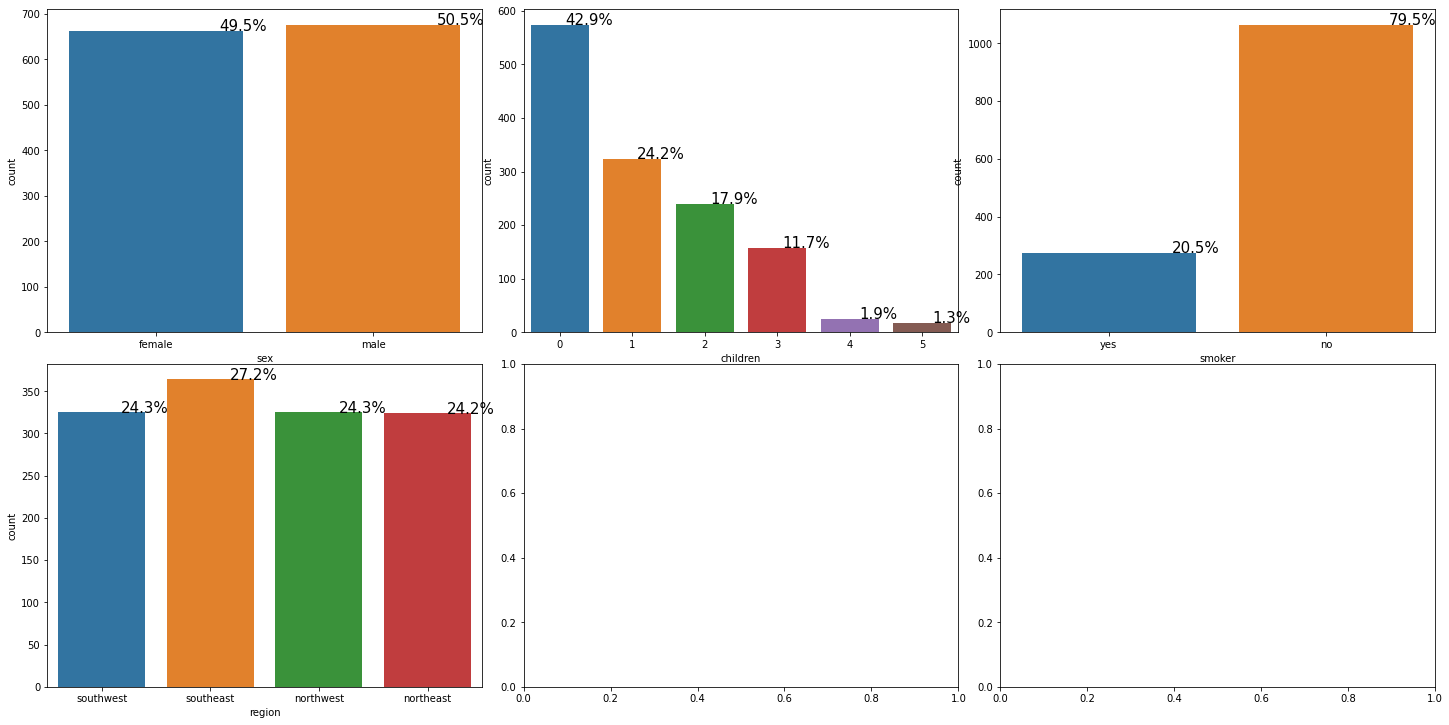

In [ ]:
categorical_features = ['sex', 'children', 'smoker', 'region']
count_plot(categorical_features, df)

- The numbers of males and females are almost the same.
- most of pepole don't have children.
- with 5 persons there is about one somkes.
- most region is southeast.

In [ ]:
def box_plot(features, df):
  fig, axis = plt.subplots((len(features) // 3), 3, figsize=(20,10))
  fig.tight_layout()
  for i in range((len(features) // 3)):
      for j in range(3):
        ax = sns.boxplot(ax=axis[j],x=features[j],data=df)

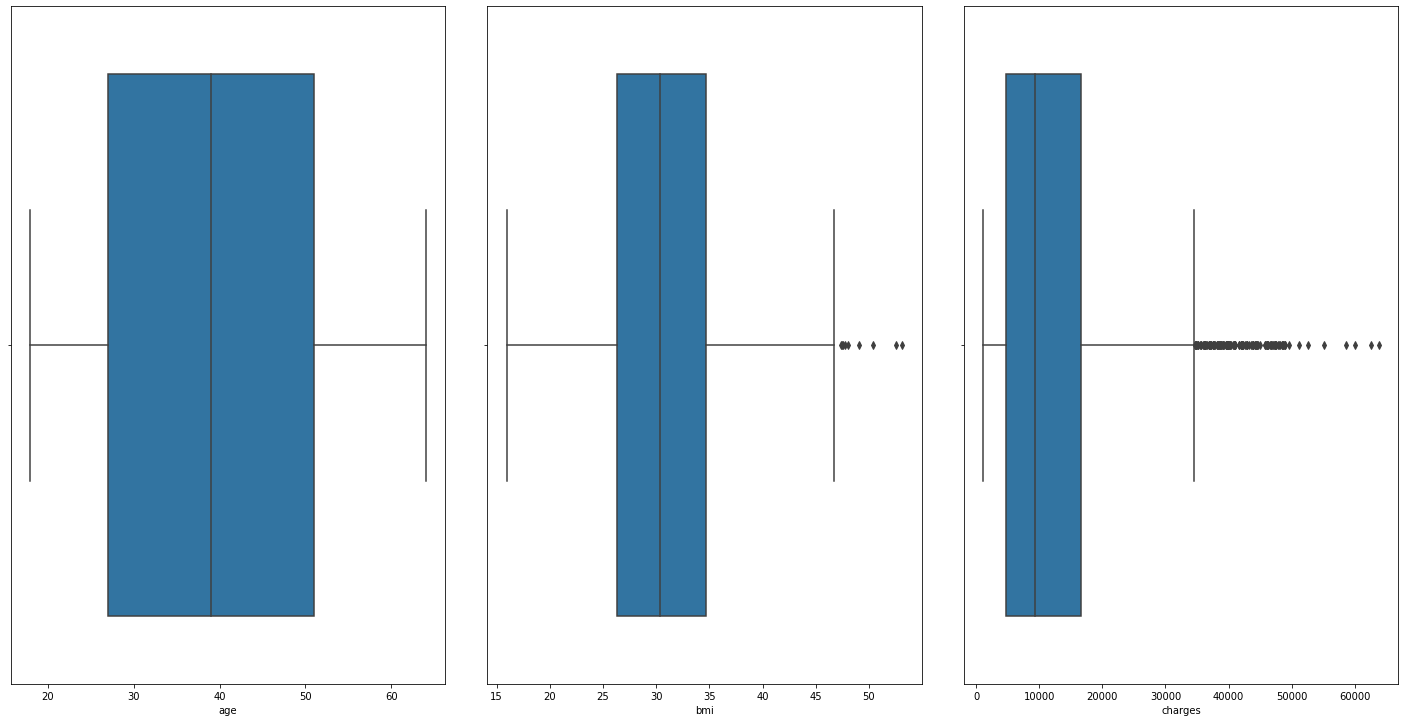

In [ ]:
numerical_features = ['age', 'bmi', 'charges']
box_plot(numerical_features, df)

- bmi and charges contain outliers

### Multivariate analysis

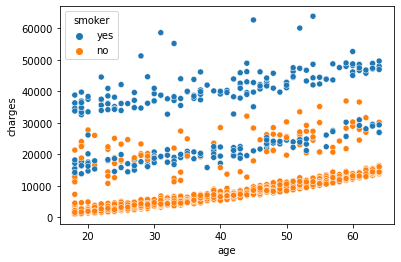

In [ ]:
sns.scatterplot(x='age', y='charges', hue="smoker", data=df)

- age only don't effect on charges
- smoking means high charges you will pay

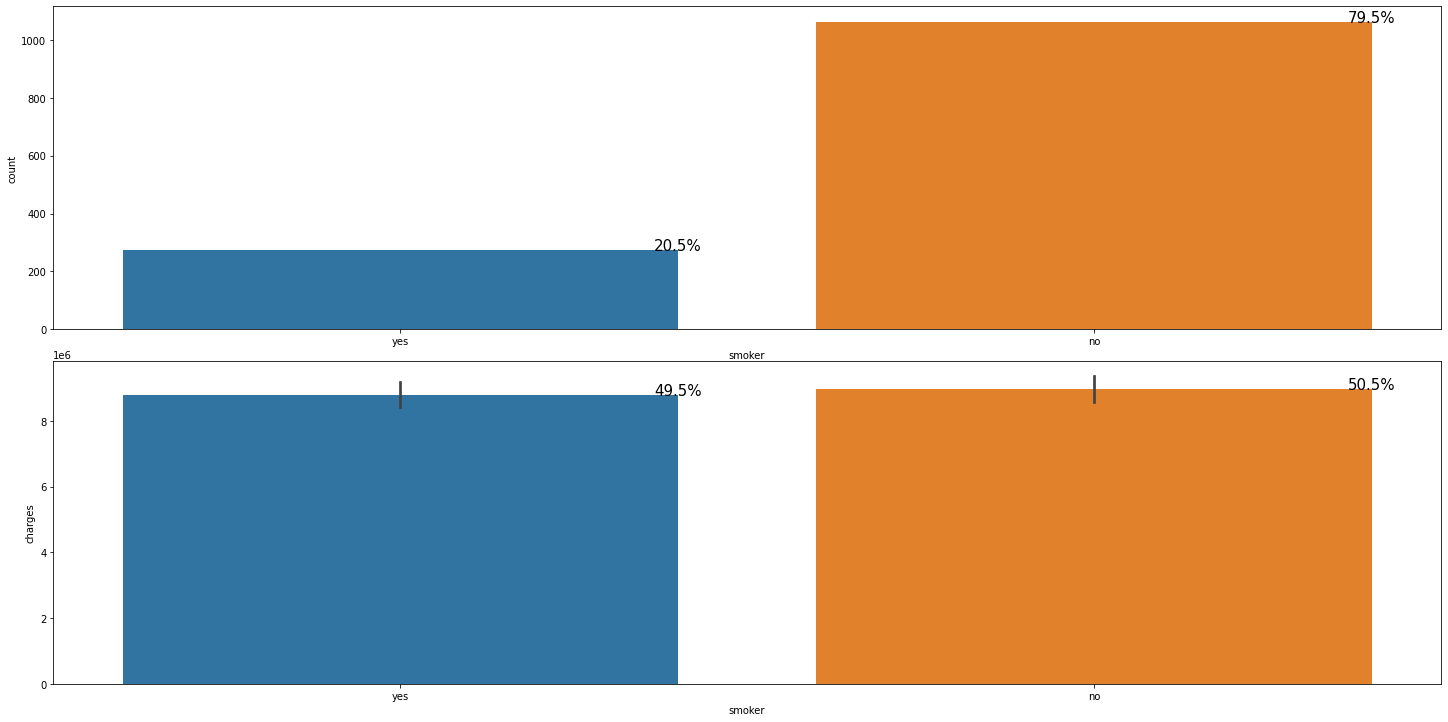

In [ ]:
axis = subplots(2,1)
ax = sns.countplot(ax=axis[0],x='smoker',data=df)
get_count_precent(ax)
ax = sns.barplot(ax=axis[1],x='smoker', y='charges', data=df, estimator=sum)
get_sum_precent(ax, 'charges')

- Even though the number of smokers is about 20% but in amount of charges smokers are paid as non-smokers paid

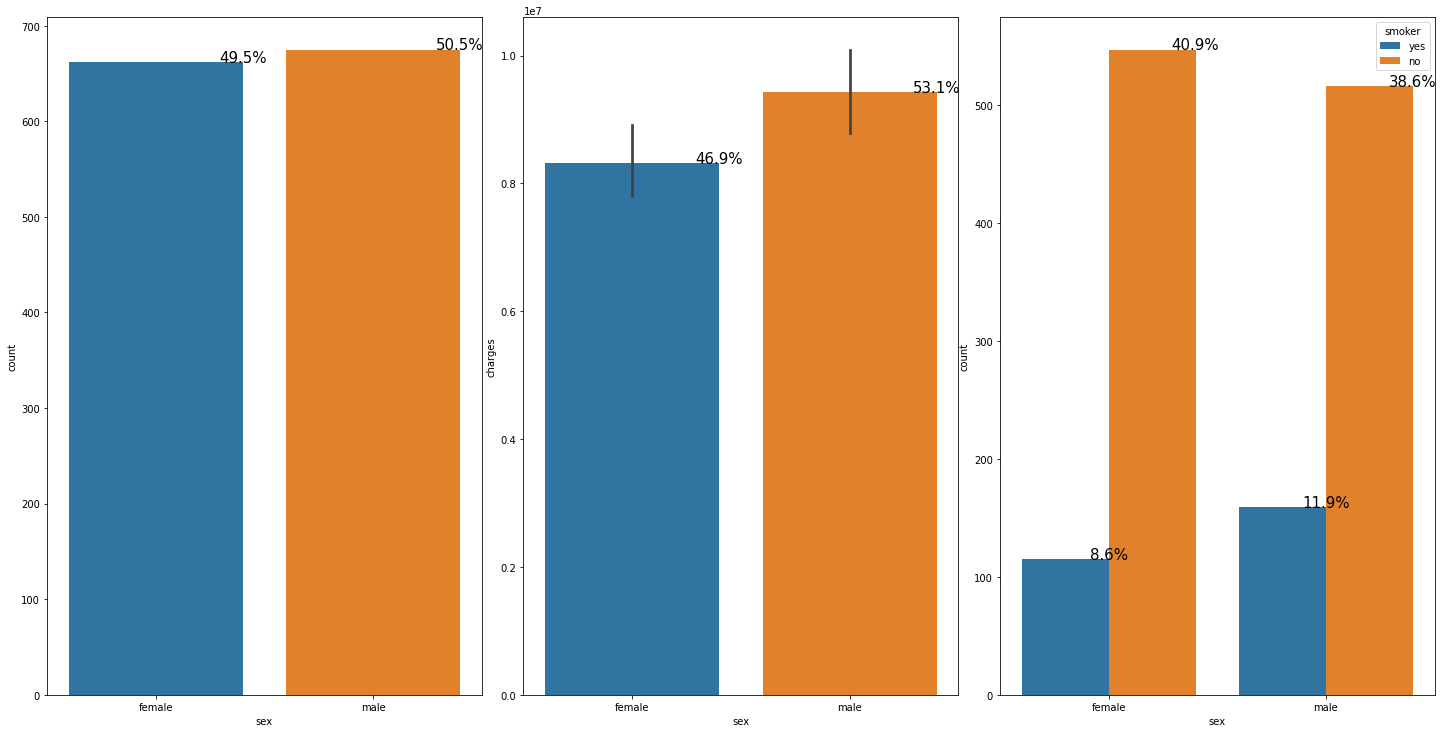

In [ ]:
axis = subplots(1,3)
ax = sns.countplot(ax=axis[0], x='sex', data=df)
get_count_precent(ax)
ax = sns.barplot(ax=axis[1], x='sex', y='charges', data=df, estimator=sum)
get_sum_precent(ax, 'charges')
ax = sns.countplot(ax=axis[2], x='sex', hue='smoker', data=df)
get_count_precent(ax)

- Males and females are approximatly equally balanced (Blanaced Data).
- Males pay charges more than females because number of male smokers are greater than female smokers.

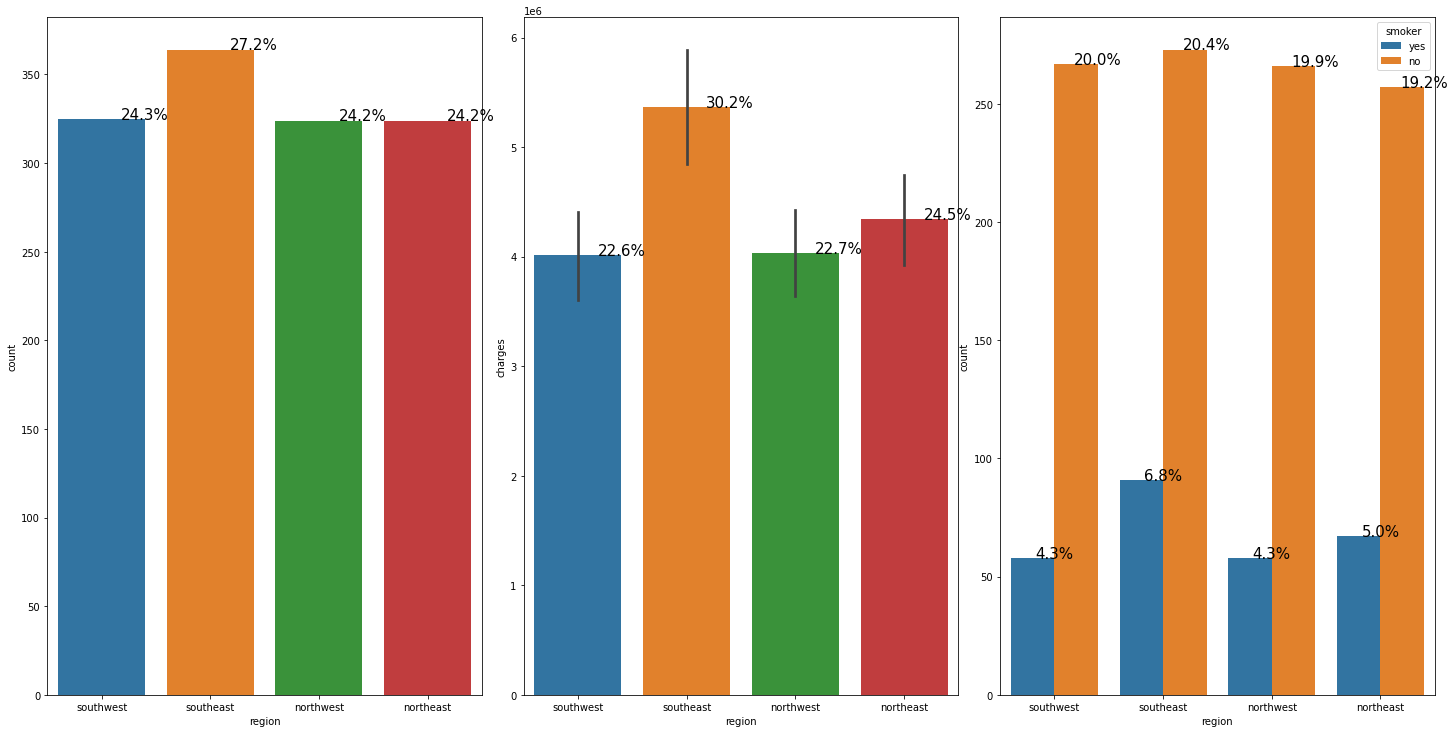

In [ ]:
axis = subplots(1,3)
ax = sns.countplot(ax=axis[0], x='region', data=df)
get_count_precent(ax)
ax = sns.barplot(ax=axis[1], x='region', y='charges', data=df, estimator=sum)
get_sum_precent(ax, 'charges')
ax = sns.countplot(ax=axis[2], x='region', hue='smoker', data=df)
get_count_precent(ax)

- Southeast is the most region in paying charges because it contains the highest number of smokers

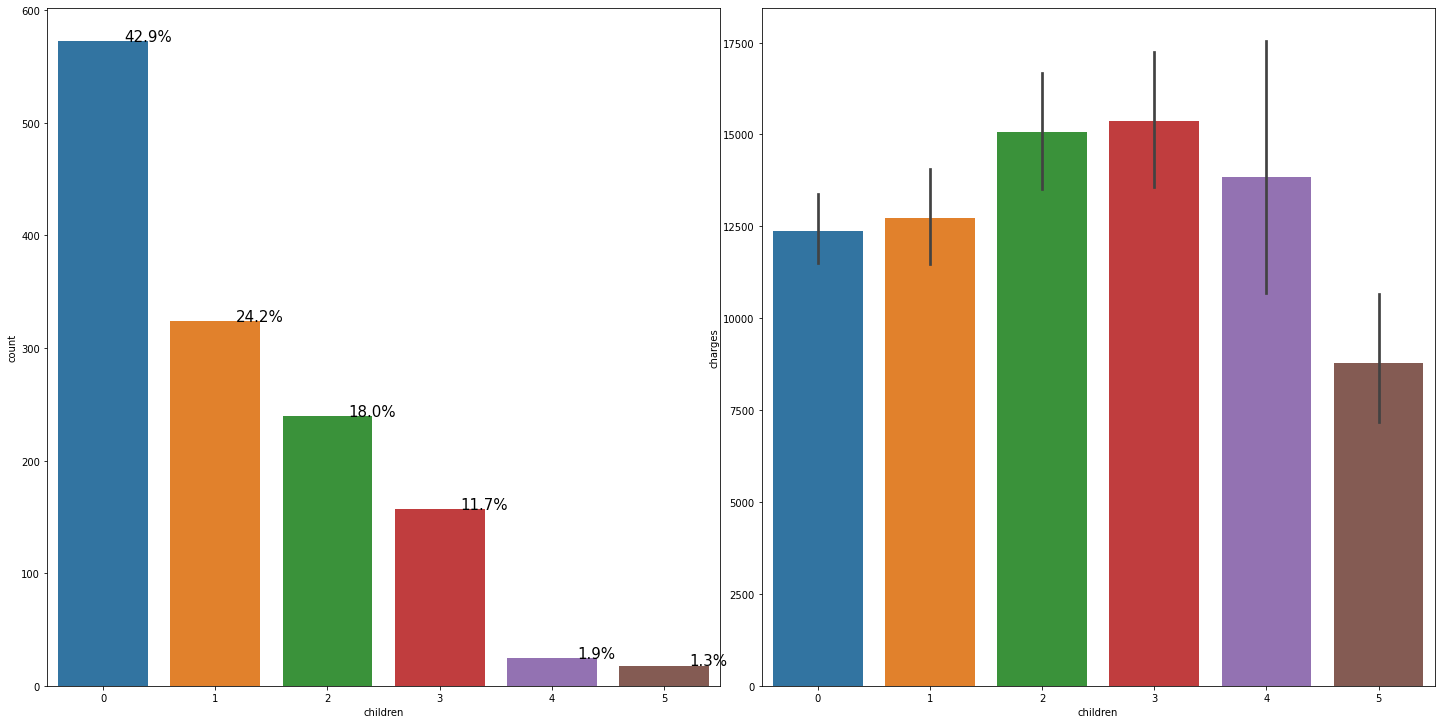

In [ ]:
axis = subplots(1,2)
ax = sns.countplot(ax=axis[0], x='children', data=df)
get_count_precent(ax)
ax = sns.barplot(ax=axis[1], x='children', y='charges', data=df)

- number of children in the data is imbalance but when take the mean to each one we notice that it don't effect on the charges

In [ ]:
df_new = pd.get_dummies(df, columns=['sex', 'region', 'children', 'smoker'])

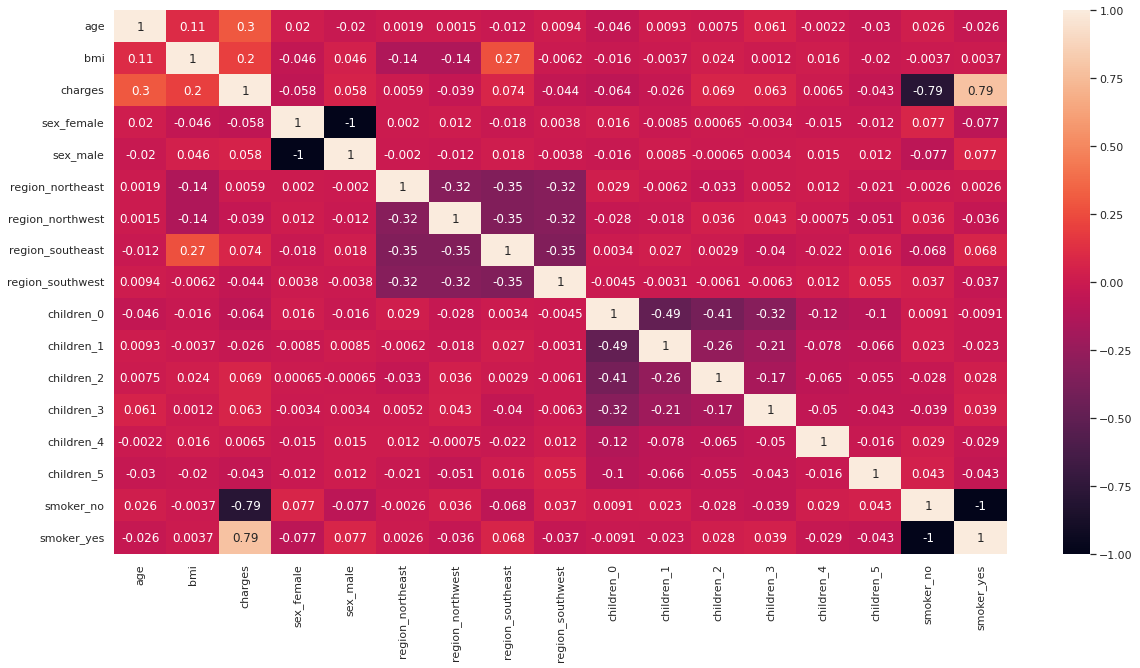

In [ ]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.heatmap(df_new.corr(), annot=True);

- we can see that most features are not linearly correlated.

<h1 style="text-align:center; font-size:100px; color:#651fff">Conclusion</h1>

- Age doesn't affect the charges.
- Smoking lead to high charges.
- Southeast has high charges because it contians high smokers.
- Males smokers more than females so, they pay more charges.
- number of children don't effect on charges.

## Data Preprocessing

In [ ]:
### CODE HERE ###
# Check for data types/count non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


No missing values in dataset

In [ ]:
# Check for skewness min,25%,50%,75%,max
data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [ ]:
stats_df = data.describe()
stats_df.loc['range'] = stats_df.loc['max'] - stats_df.loc['min']

out_fields = ['mean','25%','50%','75%', 'range']
stats_df = stats_df.loc[out_fields]
stats_df.rename({'50%': 'median'}, inplace=True)
stats_df

,age,bmi,children,charges
mean,39.207025,30.663397,1.094918,13270.422265
25%,27.000000,26.296250,0.000000,4740.287150
median,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
range,46.000000,37.170000,5.000000,62648.554110


In [ ]:
# Check for imbalance
data['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [ ]:
# Check for imbalance
data['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [ ]:
# Calculate correlation values
data_num = data.select_dtypes(include = ['float64','int64'])
corr = data_num.corr()['charges'][:-1]
top_features = corr.sort_values(ascending=False)
print("{} correlated values : \n{}".format(len(top_features),top_features))

3 correlated values : 
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


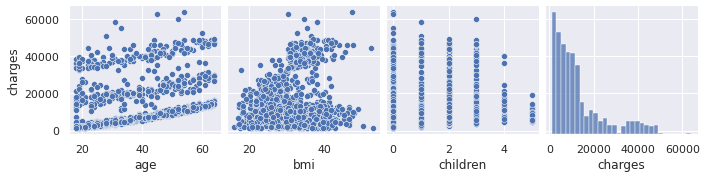

In [ ]:
# Scatter plots for all numeric features
sns.pairplot(data=data_num,x_vars=data_num.columns,y_vars=['charges'])

Skewnes = 1.5158796580240388


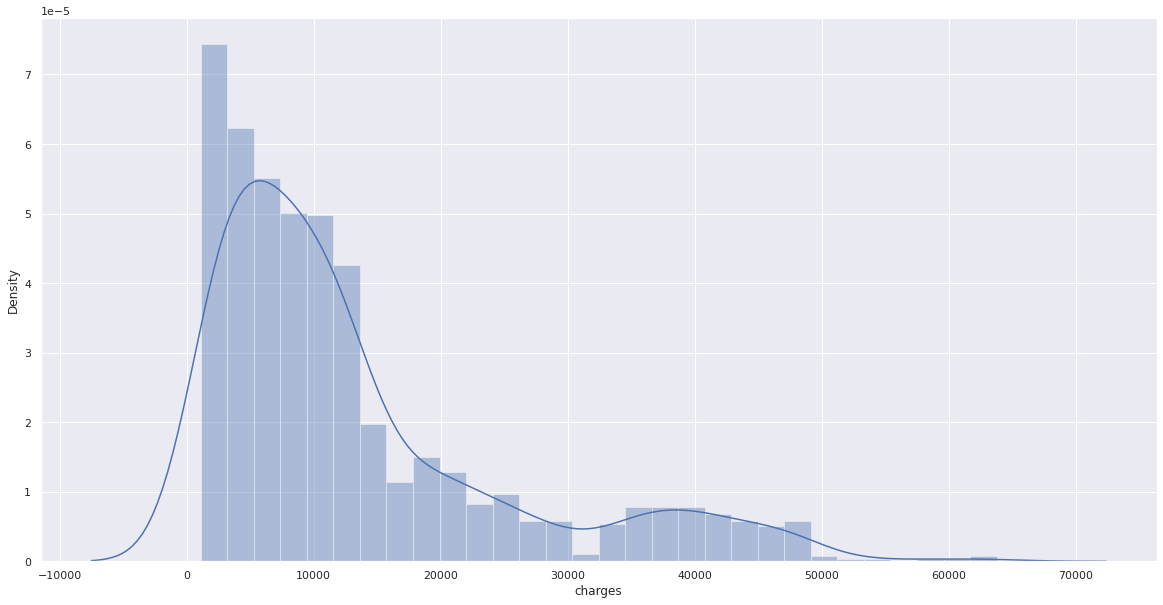

In [ ]:
# Check for skewness in target column and calculate skewness
plot = sns.distplot(data['charges'])
print("Skewnes = {}".format(data['charges'].skew()))

As you can see the target column 'charges' is positively skewed with 1.516 skewness value. We can try to correct skewness by log transforming the charges column.

Skewness = -0.09009752473024582


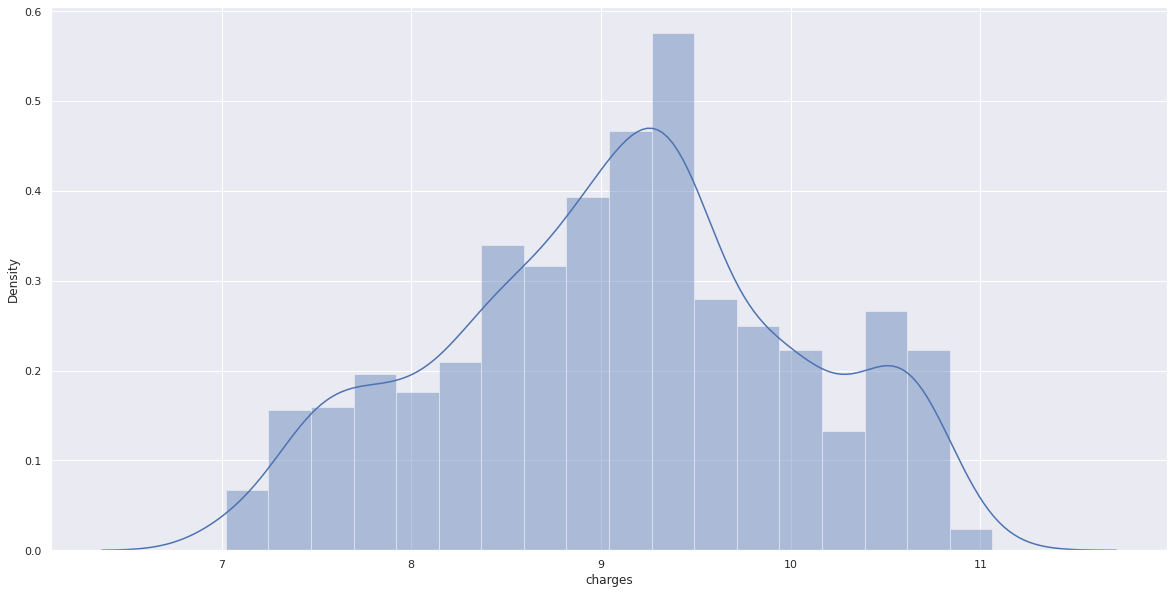

In [ ]:
log_transformed = np.log1p(data['charges'])
sns.distplot(log_transformed);
print(f"Skewness = {log_transformed.skew()}")

Log transformation managed to correct skewness

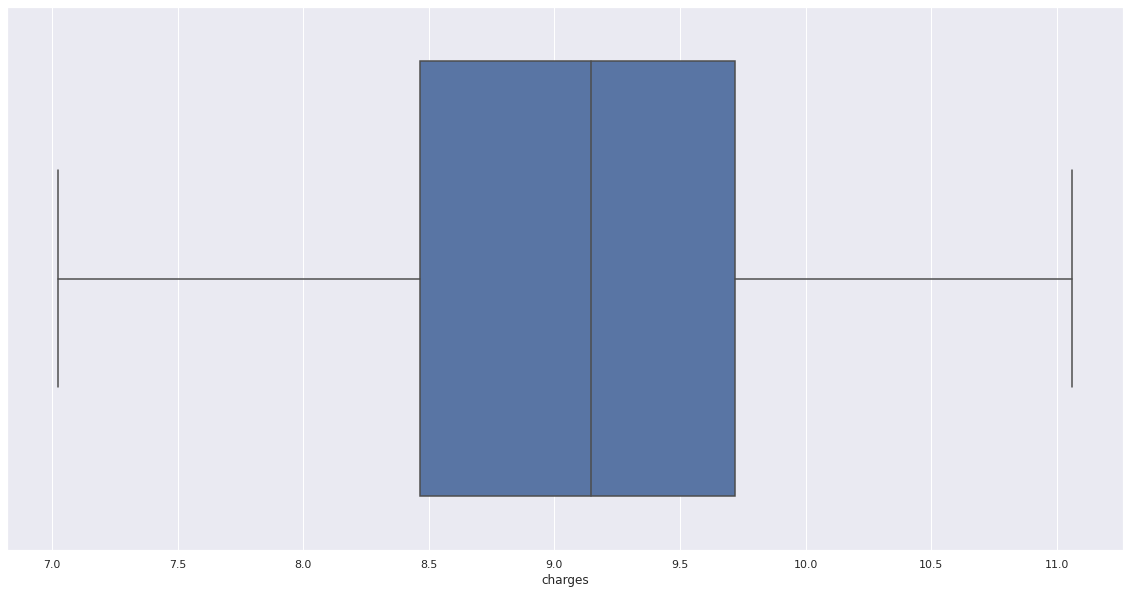

In [ ]:
# Check outliers
sns.boxplot(x=log_transformed);

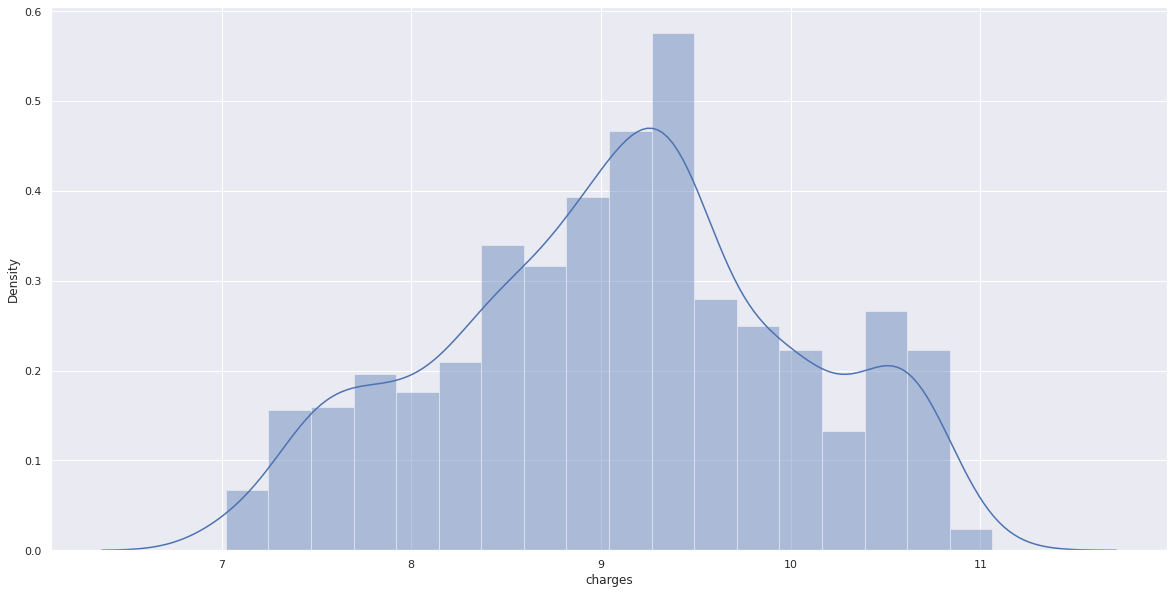

In [ ]:
# Updating charges column
data['charges']=log_transformed
sns.distplot(data['charges']);

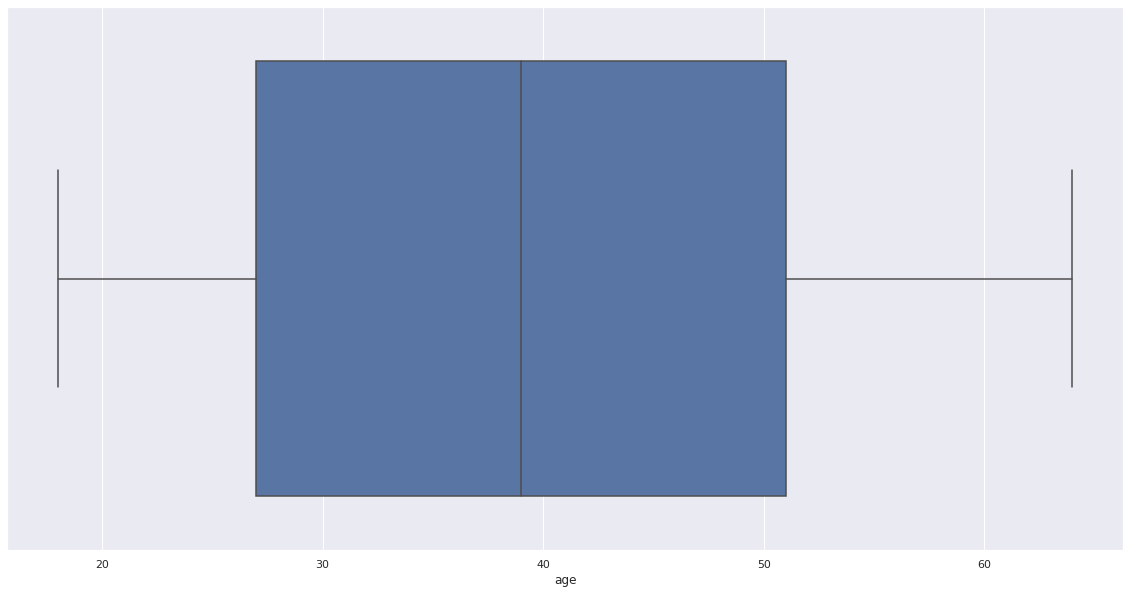

In [ ]:
# Check for outliers in features
sns.boxplot(x=data['age']);

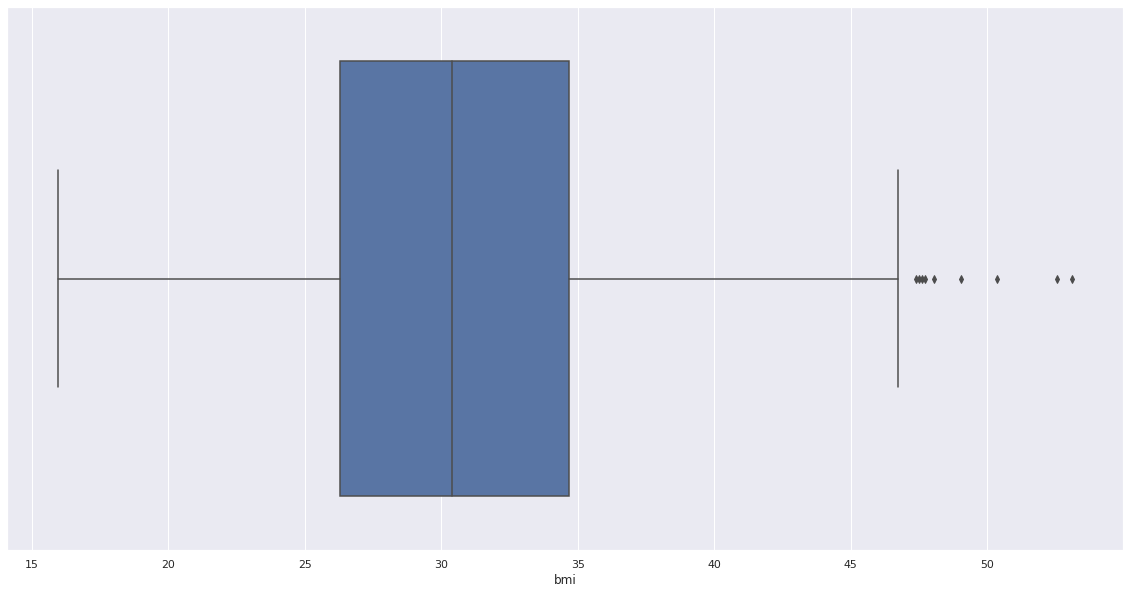

In [ ]:
sns.boxplot(x=data['bmi']);

Outliers in BMI carry useful information from the pairplot above

In [ ]:
# Calculate correlation values after log transformation
data_num = data.select_dtypes(include = ['float64','int64'])
corr = data_num.corr()['charges'][:-1]
top_features = corr.sort_values(ascending=False)
print("{} correlated values : \n{}".format(len(top_features),top_features))

3 correlated values : 
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


Correlation values enhanced

In [ ]:
# Encoding categorical data
data = pd.get_dummies(data,drop_first=True)
d2 = data.copy()
# Split into X and y
y_col = 'charges'
X = d2.drop(y_col,axis=1)
y = d2[y_col].copy()
print('X shape:',X.shape)
print('Y shape:',y.shape)

X shape: (1338, 8)
Y shape: (1338,)


In [ ]:
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


In [ ]:
# Splitting dataset into train and test set with 80%-20% ratio
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0,test_size = 0.2)

In [ ]:
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1070, 8)
y_train: (1070,)
X_test: (268, 8)
y_test: (268,)


## Linear Regression

In [ ]:
### CODE HERE ###
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [ ]:
r2_score(y_pred_lr,y_test)

0.7257340824453817

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(X_test.iloc[:,0], np.exp(y_test), color = 'blue', label = "Actual")
plt.scatter(X_train.iloc[:,0], np.exp(lr.predict(X_train)), color = 'red', label = "Predicted")
plt.xlabel('Age')
plt.ylabel('Charges')
plt.title('Actual and Predicted based on Age (Train set)')
legend = plt.legend()
plt.show()

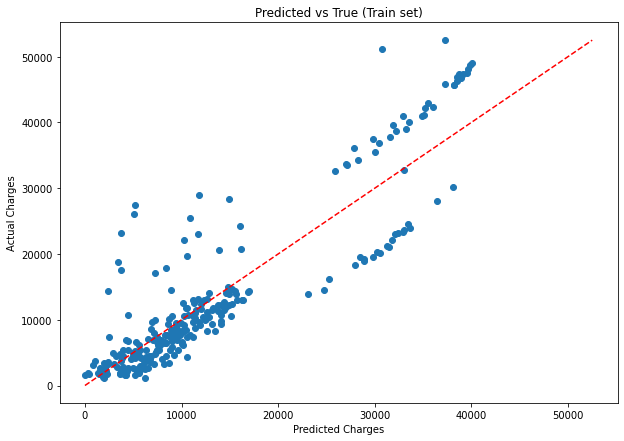

In [ ]:
line = np.arange(2, np.exp(y_test).max(), 500)
plt.figure(figsize=(10,7))
plt.plot(line, line, ls='--',color='red')
plt.scatter(x=np.exp(lr.predict(X_test)), y=np.exp(y_test))
plt.xlabel('Predicted Charges')
plt.ylabel('Actual Charges')
plt.title('Predicted vs True (Train set)')
plt.show()

In [ ]:
print(lr.coef_)
print(f"{lr.intercept_:.2f}")

In [ ]:
pd.DataFrame(zip(X.columns,lr.coef_))

,0,1
0,age,253.700500
1,bmi,335.962814
2,children,436.910121
3,sex_male,-15.463728
4,smoker_yes,23605.017267
5,region_northwest,-260.132732
6,region_southeast,-913.278834
7,region_southwest,-761.948706


Therefore, the equation of our multiple linear regression model is:

$$\textrm{Charges} = 0.03 \times \textrm{Age} + 0.01 \times \textrm{BMI} + 0.1 \times \textrm{Children} - 0.05 \times \textrm{Sex} + 1.56 \times \textrm{Smoker} - 0.05 \times \textrm{Region_1} - 0.14 \times \textrm{Region_2} - 0.12 \times \textrm{Region_3} + 6.99$$


## Polynomial Regression

In [ ]:
X_train_poly = X_train.copy()
X_test_poly = X_test.copy()
y_train_poly = y_train.copy()
y_test_poly = y_test.copy()

In [ ]:
R2_score = []
mae = []
for i in range(1,8):
    polyreg=make_pipeline(PolynomialFeatures(i,include_bias=True),LinearRegression())
    polyreg.fit(X_train_poly,y_train_poly)
    y_pred_pr = polyreg.predict(X_test_poly)
    R2_score.append(r2_score(y_pred_pr,y_test_poly))
    mae.append(mean_absolute_error(y_pred_pr,y_test_poly))

In [ ]:
print(f'this is the r2_score of test set: {R2_score}')
print(f'This is mean absolute error of the test set: {mae}')

this is the r2_score of test set: [0.7257340824453815, 0.8349310555864843, 0.850811080790333, 0.8424664229979268, 0.41953312167803436, -0.0067348849934252275, 0.0002649479569818425]
This is mean absolute error of the test set: [3933.2726494052454, 3337.7211693246268, 3312.5698625615673, 3245.9349934256566, 5444.462578548395, 232768.46956832125, 1286336.9544239945]


R2 Score is:  0.850811080790333
Mean Absolute Error:  3312.5698625615673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp2
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step


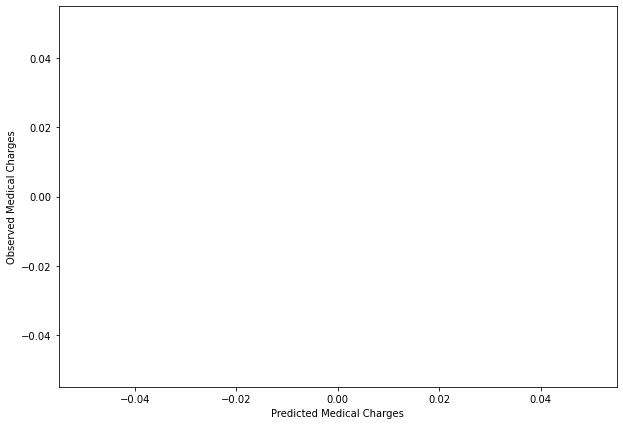

In [ ]:
polyreg = make_pipeline(PolynomialFeatures(degree=3,include_bias=True),LinearRegression())
polyreg.fit(X_train_poly,y_train_poly)
y_pred_pr = polyreg.predict(X_test_poly)
r2_score = r2_score(y_pred_pr,y_test_poly)
mean_absolute_error = mean_absolute_error(y_pred_pr,y_test_poly)
print("R2 Score is: ",r2_score)
print("Mean Absolute Error: ", mean_absolute_error)
plt.figure(figsize=(10,7))
plt.scatter(np.exp2(y_pred_pr),np.exp2(y_test_poly))
plt.xlabel("Predicted Medical Charges")
line = np.linspace(2,np.exp2(y_test_poly).max(),500)
plt.plot(line,line,ls='--',color='red')
plt.ylabel("Observed Medical Charges")
plt.show()

## Support Vector Regression (SVR)

In [ ]:
### CODE HERE ###
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
kf = KFold(shuffle=True,n_splits=3,random_state=42)
estimator_svr = Pipeline([("pf",PolynomialFeatures()),
                          ("scaler",StandardScaler()),
                          ("svr",SVR())])
params_svr = {'svr__kernel':['rbf','linear','sigmoid'],
              'pf__degree':[x for x in range(1,6)]}
grid_svr = GridSearchCV(estimator_svr,params_svr,cv=kf)


In [ ]:
grid_svr.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pf', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             param_grid={'pf__degree': [1, 2, 3, 4, 5],
                         'svr__kernel': ['rbf', 'linear', 'sigmoid']})

In [ ]:
grid_svr.best_params_

{'pf__degree': 3, 'svr__kernel': 'linear'}

In [ ]:
y_pred_svr = grid_svr.predict(X_test)

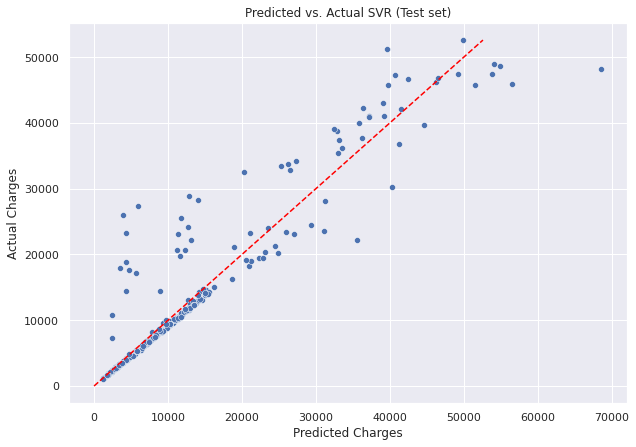

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(np.exp(y_pred_svr),np.exp(y_test));
plt.xlabel('Predicted Charges')
plt.ylabel('Actual Charges')
plt.title('Predicted vs. Actual SVR (Test set)')
l = np.linspace(0,np.exp(y_test).max(),500);
plt.plot(l,l,ls='--',color='red');

## Lasso Regression

In [ ]:
### CODE HERE ###
estimator_las = Pipeline([("polynomial_features",PolynomialFeatures()),
                      ("scaler",StandardScaler()),
                      ("las_regression",Lasso(max_iter=10**5))])

params_las = {'polynomial_features__degree':range(4,8),
            'las_regression__alpha':np.geomspace(0.05,0.1,5)}

kf = KFold(shuffle=True,random_state=42,n_splits=3)


In [ ]:
grid_las = GridSearchCV(estimator_las,params_las,cv=kf)
grid_las.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('las_regression',
                                        Lasso(max_iter=100000))]),
             param_grid={'las_regression__alpha': array([0.05      , 0.05946036, 0.07071068, 0.08408964, 0.1       ]),
                         'polynomial_features__degree': range(4, 8)})

In [ ]:
grid_las.best_params_

{'las_regression__alpha': 0.05, 'polynomial_features__degree': 6}

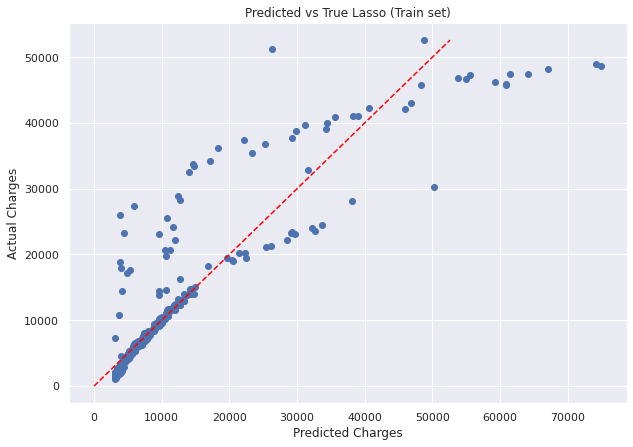

In [ ]:
y_pred_las = grid_las.predict(X_test)
line = np.linspace(2, np.exp(y_test).max(), 500)
plt.figure(figsize=(10,7))
plt.plot(line, line, ls='--',color='red')
plt.scatter(x=np.exp(y_pred_las), y=np.exp(y_test))
plt.xlabel('Predicted Charges')
plt.ylabel('Actual Charges')
plt.title('Predicted vs True Lasso (Train set)')
plt.show()

## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.model_selection import GridSearchCV

kf = KFold(shuffle=True,random_state=42,n_splits=3)
parameters = {'alpha':[0.1,0.2,0.3,0.4,0.7,1,5, 10]}

Ridge_reg= GridSearchCV(Ridge(), parameters,cv=kf)

#fit the grid search
Ridge_reg.fit(X_train,y_train)

# best estimator
print(Ridge_reg.best_estimator_)

# best model
Ridge_reg = Ridge_reg.best_estimator_
Ridge_reg.fit(X_train,y_train)

Ridge(alpha=0.2)


Ridge(alpha=0.2)

In [ ]:
y_pred_ridge = Ridge_reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,y_pred_ridge)

0.26337185034790656

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred_ridge)

0.17609004270267326

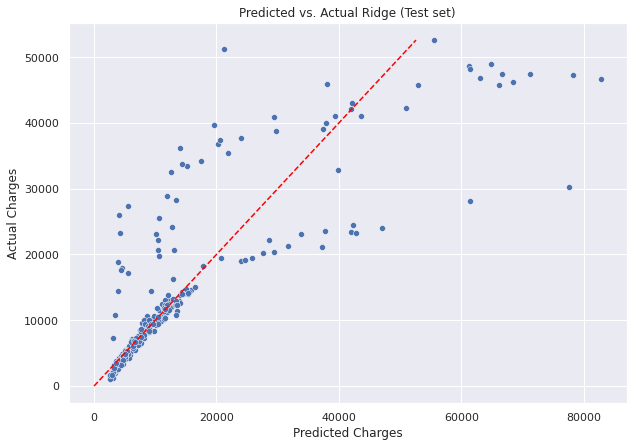

In [ ]:
plt.figure(figsize=(10,7));
sns.scatterplot(np.exp(y_pred_ridge),np.exp(y_test));
plt.xlabel('Predicted Charges')
plt.ylabel('Actual Charges')
plt.title('Predicted vs. Actual Ridge (Test set)')
l = np.linspace(0,np.exp(y_test).max(),500);
plt.plot(l,l,ls='--',color='red');

## ElasticNet Regression

In [ ]:
### CODE HERE ###
from sklearn.linear_model import ElasticNet
kf = KFold(shuffle=True,random_state=42,n_splits=3)
estimator_elas = Pipeline([("polynomial_features",PolynomialFeatures()),
                          ("scaler",StandardScaler()),
                          ("elas_regression",ElasticNet(max_iter=100000))])
params_elas = {'polynomial_features__degree':[x for x in range(1,6)],
              'elas_regression__alpha':np.geomspace(0.05,1,5),
              'elas_regression__l1_ratio':np.geomspace(0.05,1,5)}


In [ ]:
grid_elas = GridSearchCV(estimator_elas,params_elas,cv=kf)
grid_elas.fit(X_train,y_train);
y_pred_elas = grid_elas.predict(X_test)

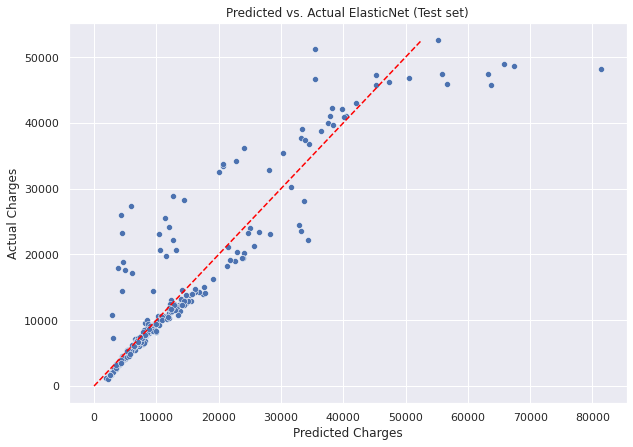

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(np.exp(y_pred_elas),np.exp(y_test));
plt.xlabel('Predicted Charges')
plt.ylabel('Actual Charges')
plt.title('Predicted vs. Actual ElasticNet (Test set)')
l = np.linspace(0,np.exp(y_test).max(),500);
plt.plot(l,l,ls='--',color='red');

In [ ]:
grid_elas.best_params_

{'elas_regression__alpha': 0.05,
 'elas_regression__l1_ratio': 0.05,
 'polynomial_features__degree': 3}

In [ ]:
print('Sum of Magnitude of coef: ',(abs(grid_elas.best_estimator_.named_steps['elas_regression'].coef_)).sum())
print('Number of coef=0 : ',(grid_elas.best_estimator_.named_steps['elas_regression'].coef_==0).sum())

Sum of Magnitude of coef:  2.894019625490066
Number of coef=0 :  66


## XGBRegressor

In [ ]:
### CODE HERE ###
kf = KFold(shuffle=True,random_state=42,n_splits=3)
estimator_xgb = Pipeline([("polynomial_features",PolynomialFeatures()),
                          ("scaler",StandardScaler()),
                          ("xgb_regression",XGBRegressor(verbosity=0))])
params_xgb = {'polynomial_features__degree':[1,2,3],
              'xgb_regression__n_estimators':[100,200,300,400,500],
              'xgb_regression__max_depth':[3,4,5,6]}
grid_xgb = GridSearchCV(estimator_xgb,params_xgb,cv=kf)
grid_xgb.fit(X_train,y_train);
y_pred_xgb = grid_xgb.predict(X_test)

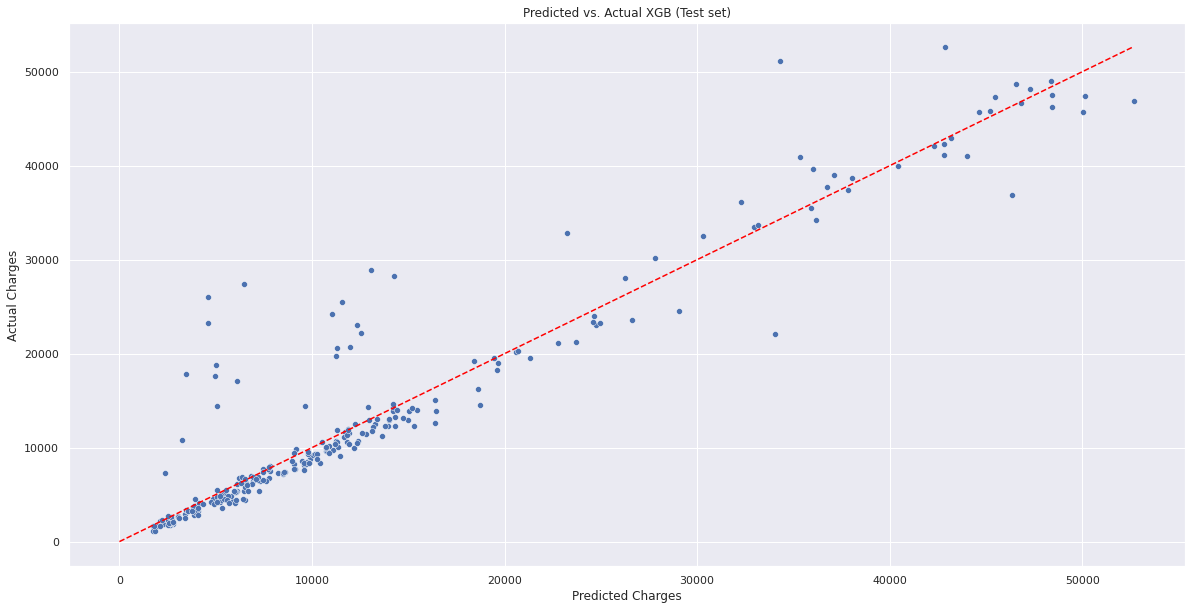

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(np.exp(y_pred_xgb),np.exp(y_test));
plt.xlabel('Predicted Charges')
plt.ylabel('Actual Charges')
plt.title('Predicted vs. Actual XGB (Test set)')
l = np.linspace(0,np.exp(y_test).max(),500);
plt.plot(l,l,ls='--',color='red');

In [ ]:
grid_xgb.best_params_

{'polynomial_features__degree': 1,
 'xgb_regression__max_depth': 3,
 'xgb_regression__n_estimators': 100}

## Decision Tree Regression

In [ ]:
### CODE HERE ###
from sklearn.tree import DecisionTreeRegressor
treeRegressionModel = DecisionTreeRegressor(random_state=42)
treeRegressionModel.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
treeRegressionModel.score(X_test, y_test)

0.7537519939105043

In [ ]:
scores = {}
for depth in range(1, 16):
  treeRegressionModel = DecisionTreeRegressor(random_state=42, max_depth=depth)
  treeRegressionModel.fit(X_train, y_train)
  treeRegressionModel.score(X_test, y_test)
  scores[depth] = treeRegressionModel.score(X_test, y_test)

print(scores)

{1: 0.4854970000444486, 2: 0.7325949694451155, 3: 0.8085751199144577, 4: 0.855158881564871, 5: 0.8595286565226159, 6: 0.8723440255242721, 7: 0.8449325703408039, 8: 0.8418729413154895, 9: 0.8104647334736298, 10: 0.7950920998386894, 11: 0.7996855925197555, 12: 0.7924760433419443, 13: 0.7761908839114822, 14: 0.7606607110661149, 15: 0.7764795558430276}


6 is the highest Score

In [ ]:
treeRegressionModel = DecisionTreeRegressor(random_state=42, max_depth=6)
treeRegressionModel.fit(X_train, y_train)
y_pred_dt = treeRegressionModel.predict(X_test)
treeRegressionModel.score(X_test, y_test)

0.8723440255242721

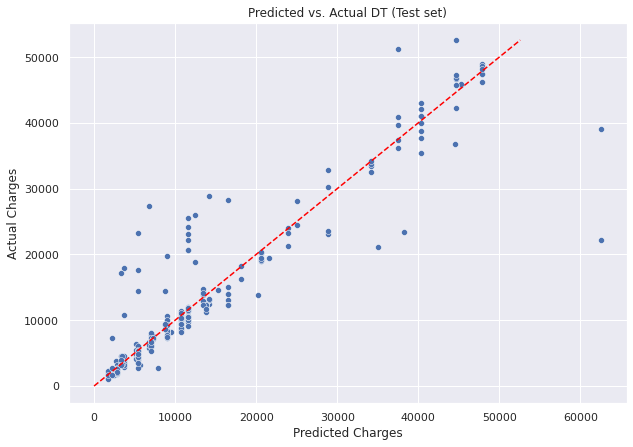

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(np.exp(y_pred_dt),np.exp(y_test));
plt.xlabel('Predicted Charges')
plt.ylabel('Actual Charges')
plt.title('Predicted vs. Actual DT (Test set)')
l = np.linspace(0,np.exp(y_test).max(),500);
plt.plot(l,l,ls='--',color='red');

## Random Forests Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
kf = KFold(shuffle=True,random_state=42,n_splits=3)
RFregressor = RandomForestRegressor(random_state=0)
params_RF = {'n_estimators':[10,100,200,300,1000],
              'random_state':[0]}
grid_RF = GridSearchCV(RFregressor,params_RF,cv=kf)
grid_RF.fit(X_train,y_train);
y_pred_RF = grid_RF.predict(X_test)

In [ ]:
grid_RF.best_params_

{'n_estimators': 200, 'random_state': 0}

In [ ]:
grid_RF.score(X_test,y_test)

0.8669566779863076

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error (y_test,y_pred_RF)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error (y_test,y_pred_RF)

In [ ]:
plt.figure(figsize=(10,7));
sns.scatterplot(np.exp(y_pred_RF),np.exp(y_test));
plt.xlabel('Predicted Charges')
plt.ylabel('Actual Charges')
plt.title('Predicted vs. Actual Ridge (Test set)')
l = np.linspace(0,np.exp(y_test).max(),500);
plt.plot(l,l,ls='--',color='red');

## Comparison

In [ ]:
### CODE HERE ###
from sklearn.metrics import mean_squared_error,r2_score
def rmse(y_pred,y_test):
  return np.sqrt(mean_squared_error(y_pred,y_test))

In [ ]:
print('-=Simple Linear Regression=-')


print('R2 score: ',r2_score(y_pred_lr,y_test))
print('RMSE: ',rmse(y_pred_lr,y_test))

In [ ]:
print('-=Polynomial Regression=-')
print('R2 score: ',r2_score(y_pred_pr,y_test))
print('RMSE: ',rmse(y_pred_pr,y_test))

In [ ]:
print('-=SVR Regression=-')
print('R2 score: ',r2_score(y_pred_svr,y_test))
print('RMSE: ',rmse(y_pred_svr,y_test))

In [ ]:
print('-=Lasso Regression=-')
print('R2 score: ',r2_score(y_pred_las,y_test))
print('RMSE: ',rmse(y_pred_las,y_test))

In [ ]:
print('-=Ridge Regression=-')
print('R2 score: ',r2_score(y_pred_ridge,y_test))
print('RMSE: ',rmse(y_pred_ridge,y_test))

In [ ]:
print('-=ElasticNet Regression=-')
print('R2 score: ',r2_score(y_pred_elas,y_test))
print('RMSE: ',rmse(y_pred_elas,y_test))

In [ ]:
print('-=XGB Regression=-')
print('R2 score: ',r2_score(y_pred_xgb,y_test))
print('RMSE: ',rmse(y_pred_xgb,y_test))

In [ ]:
print('-=Decision Tree Regression=-')
print('R2 score: ',r2_score(y_pred_dt,y_test))
print('RMSE: ',rmse(y_pred_dt,y_test))

In [ ]:
print('-=Random Forest Regression=-')
print('R2 score: ',r2_score(y_pred_RF,y_test))
print('RMSE: ',rmse(y_pred_RF,y_test))